In [1]:
from datetime import date, timedelta
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
cl = lambda x : x.drop('Unnamed: 0',axis=1,inplace=True)

In [13]:
forecasted = pd.read_csv('forecasted_final.csv')
cl(forecasted)
forecasted.Material=forecasted.Material.astype(str)

In [82]:
forecasted.leadtime = forecasted.leadtime.astype(int)

In [14]:
forecasted.head()

,Material,Desc,leadtime,max_leadtime,SAP_forecasted,year,cons_wip,cons_woip,buffer_stock,pre_net,present_stock,net_req,oem
0,100000705,GAS REFRIGERATION 404A,100.0,100.0,0.0,2025,1,1,1.0,2.0,1.0,1.0,NaN
1,100000705,GAS REFRIGERATION 404A,100.0,100.0,0.0,2026,1,1,1.0,2.0,0.0,1.0,NaN
2,100000705,GAS REFRIGERATION 404A,100.0,100.0,0.0,2027,1,1,1.0,2.0,1.0,1.0,NaN
3,100000705,GAS REFRIGERATION 404A,100.0,100.0,0.0,2028,1,1,1.0,2.0,1.0,1.0,NaN
4,100000705,GAS REFRIGERATION 404A,100.0,100.0,0.0,2029,1,1,1.0,2.0,1.0,1.0,NaN


In [15]:
forecasted.oem.value_counts()

oem
atlas    110
Name: count, dtype: int64

In [169]:
def makedaywiseForecast(df_yearly,mat,oem,end_date=date.today()+timedelta(days=365*5),initial_stock=10):
    daywiseForecast = pd.DataFrame(columns=['Material','Desc','leadtime','date','daily_cons','anticipated_consum','buffer_stock','present_stock','stock_after'])
    df=df_yearly.copy()
    df=df[(df['Material']==mat)&(df['oem']==oem)].reset_index(drop=True)
    consider_pre_order = False
    start_date = date.today()
    days = (end_date-start_date).days
    initial_stock = df.at[0,'cons_wip']*2
    daywiseForecast.at[0,'present_stock'] = initial_stock if df.at[0,'buffer_stock'] < initial_stock else df.at[0,'buffer_stock']*1.2
    daywiseForecast.at[0,'stock_after']=daywiseForecast.at[0,'present_stock']
    reorder_point=end_date+timedelta(days=2)
    reorder_qty,updated_reorder_qty=0,0
    first_reorder=False
    leadtime = df['leadtime'].iloc[0]
    arrival={}
    for i in range(days):
        daywiseForecast.at[i,'date']=start_date+timedelta(days=i)
        daywiseForecast.at[i,'anticipated_consum']=df.loc[df['year']==date.today().year,'cons_woip'].iloc[0]*leadtime/365
        daywiseForecast.at[i,'buffer_stock']=df.loc[df['year']==date.today().year,'buffer_stock'].iloc[0]
        daywiseForecast.at[i,'daily_cons']=df.loc[df['year']==date.today().year,'cons_wip'].iloc[0]/365
        if i>0:
            if i in arrival.keys():
                arrived_qty = arrival[i]
            else:
                arrived_qty=0
            daywiseForecast.at[i,'present_stock']=max(daywiseForecast.at[i-1,'present_stock']-daywiseForecast.at[i-1,'daily_cons'],0)
            daywiseForecast.at[i,'stock_after']=max(daywiseForecast.at[i-1,'stock_after']-daywiseForecast.at[i-1,'daily_cons'],0)+arrived_qty
            if not first_reorder:
                if daywiseForecast.at[i,'present_stock']< daywiseForecast.at[i,'buffer_stock']:
                    reorder_point = daywiseForecast.at[i,'date']
                    first_reorder = True
                    current_year=daywiseForecast.at[i,'date'].year
                    reorder_qty = df.loc[df['year']==date.today().year,'cons_wip'].iloc[0] + daywiseForecast.at[i,'anticipated_consum'] +  daywiseForecast.at[i,'buffer_stock'] - daywiseForecast.at[i, 'present_stock']
                    arrival[i+leadtime]=reorder_qty
    daywiseForecast['Material']=mat
    daywiseForecast['Desc']=df.at[0,'Desc']
    daywiseForecast['leadtime']=df['leadtime'].iloc[0]
    date_for_stock_check = reorder_point+timedelta(days=(365+int(leadtime)))
    if date_for_stock_check < end_date:
        if daywiseForecast[daywiseForecast['date']==date_for_stock_check]['present_stock'].iloc[0] == 0:
            consider_pre_order = True
            updated_period = daywiseForecast[daywiseForecast['date'].between(date.today(),reorder_point)]
            updated_reorder_qty = reorder_qty - updated_period['daily_cons'].values.sum()
    return daywiseForecast.reset_index(drop=True),{'reorder_point':reorder_point,'reorder_qty': np.ceil(reorder_qty),'updated_reorder_qty':np.ceil(updated_reorder_qty),'consider_pre_order':consider_pre_order}

In [164]:
df,results = makedaywiseForecast(forecasted,'220003196','atlas')

In [165]:
df

,Material,Desc,leadtime,date,daily_cons,anticipated_consum,buffer_stock,present_stock,stock_after
0,220003196,OIL FILTER,709,2025-07-18,0.035616,25.252055,39.0,46.8,46.8
1,220003196,OIL FILTER,709,2025-07-19,0.035616,25.252055,39.0,46.764384,46.764384
2,220003196,OIL FILTER,709,2025-07-20,0.035616,25.252055,39.0,46.728767,46.728767
3,220003196,OIL FILTER,709,2025-07-21,0.035616,25.252055,39.0,46.693151,46.693151
4,220003196,OIL FILTER,709,2025-07-22,0.035616,25.252055,39.0,46.657534,46.657534
...,...,...,...,...,...,...,...,...,...
1820,220003196,OIL FILTER,709,2030-07-12,0.035616,25.252055,39.0,0,20.230137
1821,220003196,OIL FILTER,709,2030-07-13,0.035616,25.252055,39.0,0,20.194521
1822,220003196,OIL FILTER,709,2030-07-14,0.035616,25.252055,39.0,0,20.158904
1823,220003196,OIL FILTER,709,2030-07-15,0.035616,25.252055,39.0,0,20.123288


In [166]:
results

{'reorder_point': datetime.date(2026, 2, 22),
 'reorder_qty': 39.0,
 'updated_reorder_qty': 0,
 'consider_pre_order': False}

In [112]:
def plot_req2(dff,tagw,mat,ro_p,leadtime):
  result=dff.copy()
  plt.figure(figsize=(12, 4))
  for t in tagw:
    t1=result[t].to_list()
    y1=result['date'].to_list()
    plt.plot(y1,t1, label=t,marker='o', linestyle='-')
  plt.axvline(x=ro_p, color='red', linestyle='--', label=f"reorder point at {ro_p.strftime('%d-%m-%Y')}")
  plt.axvline(x=ro_p+timedelta(days=leadtime), color='red', linestyle='--', label=f"delivery point at {(ro_p+timedelta(days=leadtime)).strftime('%d-%m-%Y')}")
  plt.hlines(max(t1), ro_p, ro_p+timedelta(days=leadtime), colors='k', linestyles='--', label='leadtime')
  plt.xticks(ticks=y1, labels=y1, rotation=45)
  plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
  plt.legend()
  plt.title(f"Forecast - {mat}")
  plt.tight_layout()
  plt.savefig(f"{mat}_1.png")
  plt.show()

In [170]:
ordering_required = {}
for mat in forecasted[forecasted.oem=='atlas'].Material.unique():
    _, ordering_required[mat] = makedaywiseForecast(forecasted,mat,'atlas')

ordering_required

{'220003196': {'reorder_point': datetime.date(2026, 2, 22),
  'reorder_qty': 39.0,
  'updated_reorder_qty': 0.0,
  'consider_pre_order': False},
 '220026293': {'reorder_point': datetime.date(2030, 7, 19),
  'reorder_qty': 0.0,
  'updated_reorder_qty': 0.0,
  'consider_pre_order': False},
 '220027684': {'reorder_point': datetime.date(2025, 12, 11),
  'reorder_qty': 3.0,
  'updated_reorder_qty': 3.0,
  'consider_pre_order': True},
 '220035026': {'reorder_point': datetime.date(2025, 12, 11),
  'reorder_qty': 3.0,
  'updated_reorder_qty': 2.0,
  'consider_pre_order': True},
 '220035027': {'reorder_point': datetime.date(2025, 12, 11),
  'reorder_qty': 3.0,
  'updated_reorder_qty': 2.0,
  'consider_pre_order': True},
 '220035032': {'reorder_point': datetime.date(2025, 12, 11),
  'reorder_qty': 3.0,
  'updated_reorder_qty': 3.0,
  'consider_pre_order': True},
 '220038299': {'reorder_point': datetime.date(2026, 2, 22),
  'reorder_qty': 3.0,
  'updated_reorder_qty': 0.0,
  'consider_pre_order':

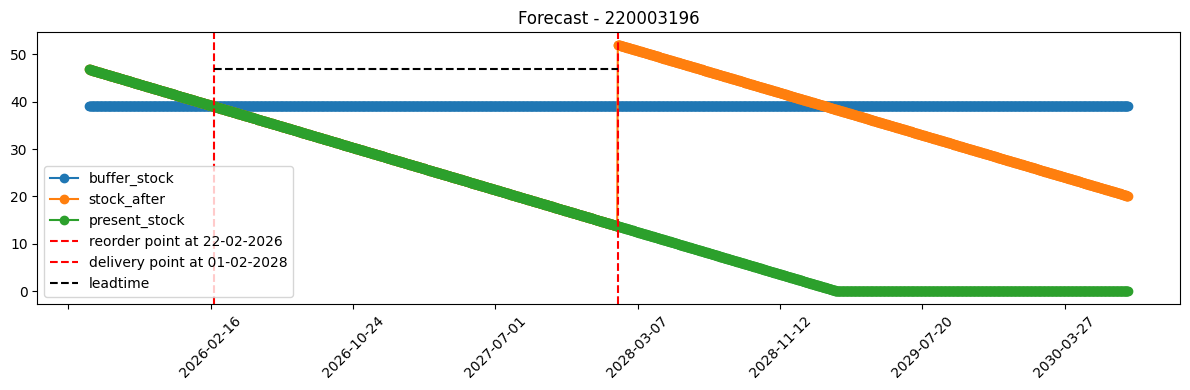

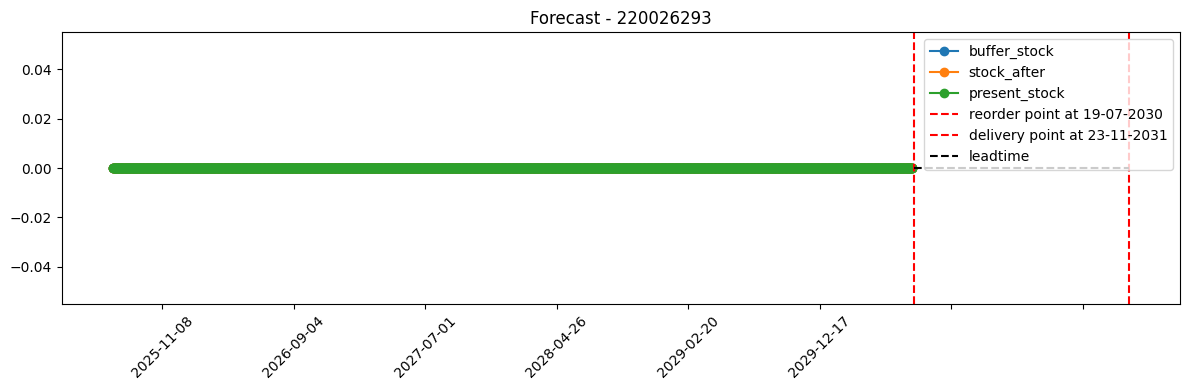

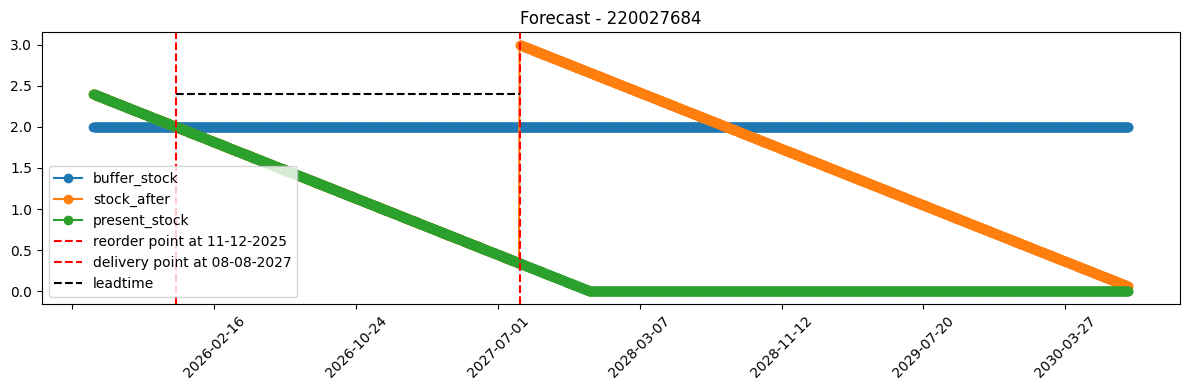

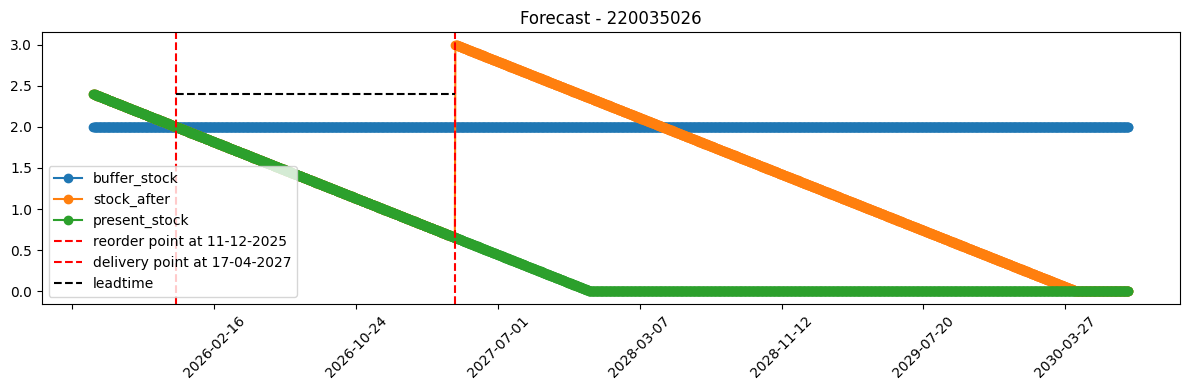

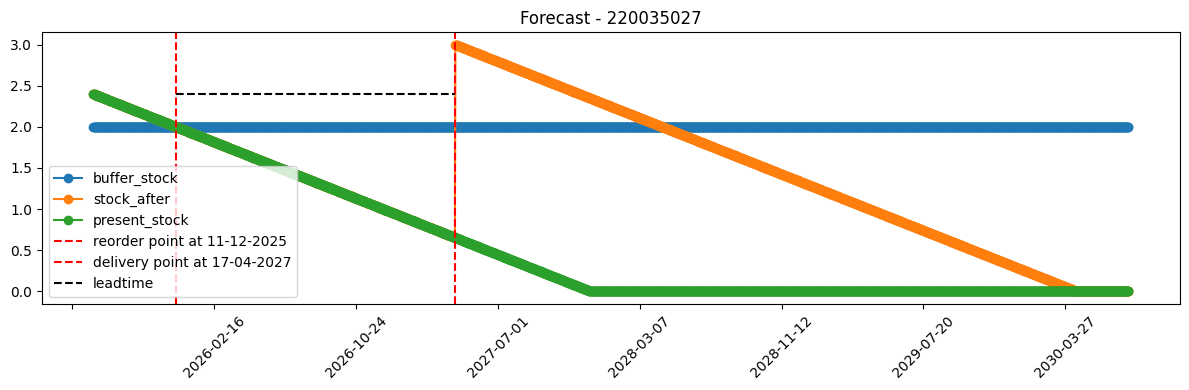

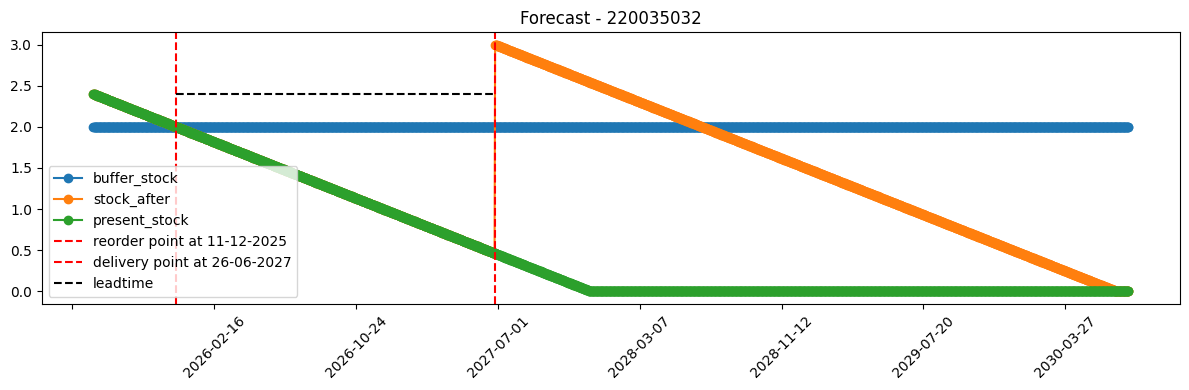

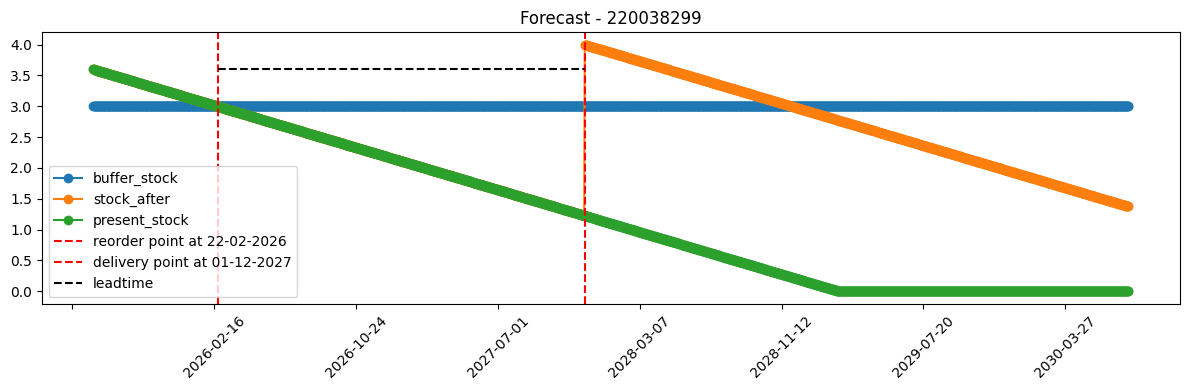

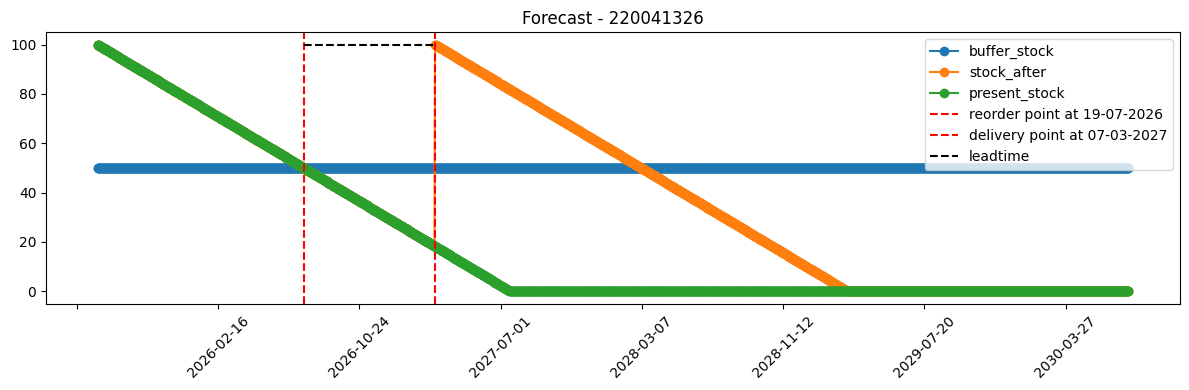

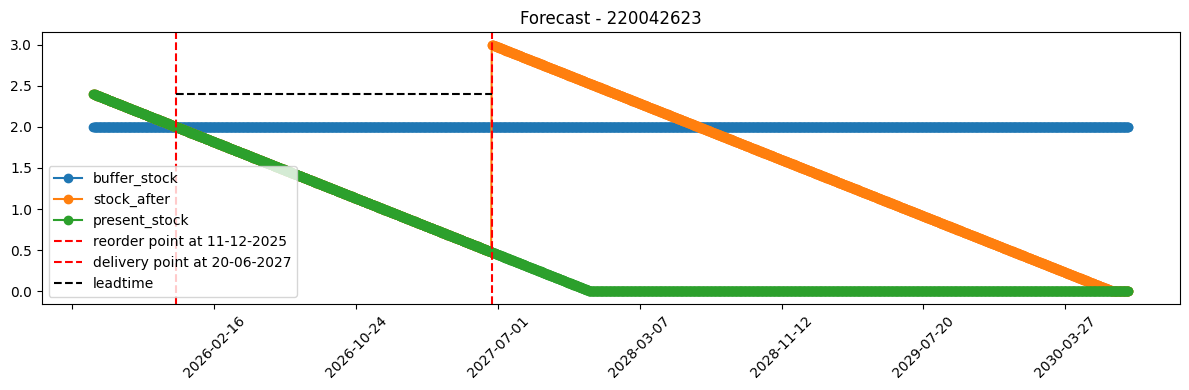

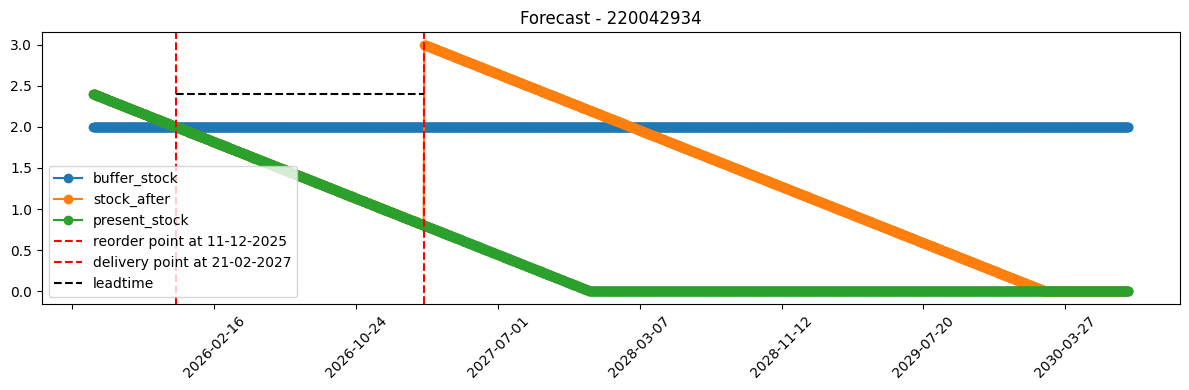

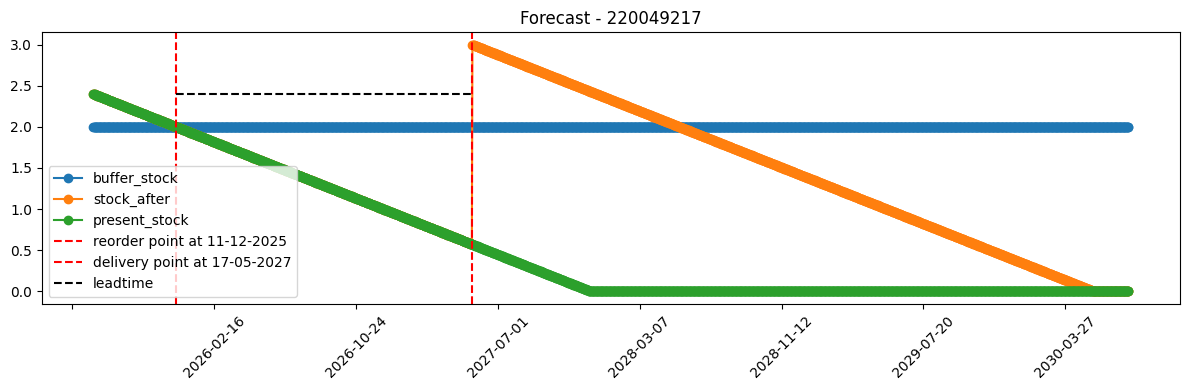

In [171]:
ordering_required[mat]={}
for mat in forecasted[forecasted.oem=='atlas'].Material.unique():
    df, ordering_required[mat] = makedaywiseForecast(forecasted,mat,'atlas')
    plot_req2(df,['buffer_stock','stock_after','present_stock'],mat,ordering_required[mat]['reorder_point'],int(df.at[0,'leadtime']))
    